# Import and Prepare Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# read Census data CSV file into dataframe for Education Scores
census_df = pd.read_csv('Census Main Analysis Data.csv', 
                     dtype={"ZIPCODE":np.int32,"STATE":'category',
                             'ZipScore':np.float32,'YEAR':np.int32,
                             'StateScore':np.float32
                     }).iloc[:,1:]

# read IRS AGI data CSV file into dataframe for Income Scores
IRS_df = pd.read_csv('IRS AGI Main Analysis Data.csv', 
                     dtype={"ZIPCODE":np.int32,"STATE":'category',
                             'ZipScore':np.float32,'YEAR':np.int32,
                             'StateScore':np.float32
                     }).iloc[:,1:]

# Create DataFrame containing only data from years 2011 and 2017 for analysis below: df_2011_2017
df_2011_2017 = pd.DataFrame(data={'ZIPCODE':[0,0],'ZipScore':[0,0]})
df_2011_2017 = df_2011_2017.merge(census_df[['ZIPCODE','ZipScore']][census_df.YEAR == 2011], 
                                  on = 'ZIPCODE', how='outer')[2:].rename(columns={'ZipScore_y':'edu_score_2011'})
df_2011_2017 = df_2011_2017.merge(census_df[['ZIPCODE','ZipScore']][census_df.YEAR == 2017], 
                                  on = 'ZIPCODE', how='outer').rename(columns={'ZipScore':'edu_score_2017'})
df_2011_2017 = df_2011_2017.merge(IRS_df[['ZIPCODE','ZipScore']][IRS_df.YEAR == 2011], 
                                  on = 'ZIPCODE', how='outer').rename(columns={'ZipScore':'income_score_2011'})
df_2011_2017 = df_2011_2017.merge(IRS_df[['ZIPCODE','ZipScore']][IRS_df.YEAR == 2017], 
                                  on = 'ZIPCODE', how='outer').rename(columns={'ZipScore':'income_score_2017'})
df_2011_2017 = df_2011_2017.drop(['ZipScore_x'], axis=1).dropna()

# Step 1: Conduct EDA
Plot ECDFs for all years available for Education and Income Scores with color variation to show change over time. **Only use 2011 and 2017 data due to intersection of annual releases of datasets**.

In [4]:
# Define ECDF function as explained in DataCamp online module (Statistical Thinking in Python - Part 1)
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

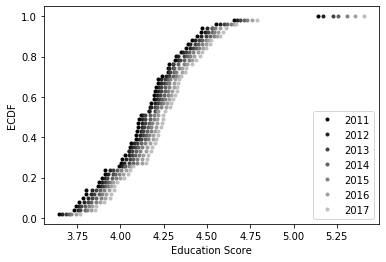

In [5]:
# Compute ECDF for Education Scores for each State for 2011-2017: x_val, y_val
census_subset_df = census_df[['STATE','StateScore','YEAR']][census_df.YEAR < 2018].drop_duplicates()

for i, yr in enumerate(census_subset_df.YEAR.unique()):
    x_val, y_val = ecdf(census_subset_df[census_subset_df.YEAR==yr].StateScore)

    # Generate plot
    plt.plot(x_val, y_val, marker = '.',linestyle = 'none',color=str(i/len(census_df.YEAR.unique())),label = str(yr))

# Label the axes
plt.xlabel('Education Score')
plt.ylabel('ECDF')
plt.legend(loc='lower right')


# Display the plot
plt.show()

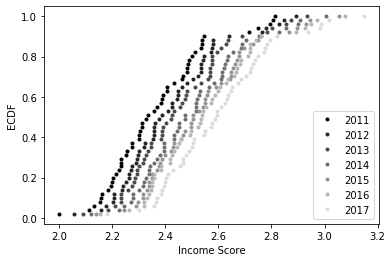

In [6]:
# Compute ECDF for Income Scores for each State 2011-2017: x_val, y_val

irs_subset_df = IRS_df[['STATE','StateScore','YEAR']][IRS_df.YEAR > 2010].drop_duplicates()

for i, yr in enumerate(irs_subset_df.YEAR.unique()):
    x_val, y_val = ecdf(irs_subset_df[irs_subset_df.YEAR==yr].StateScore)

    # Generate plot
    plt.plot(x_val, y_val, marker = '.',linestyle = 'none',color=str(i/len(irs_subset_df.YEAR.unique())),label = str(yr))

# Label the axes
plt.xlabel('Income Score')
plt.ylabel('ECDF')
plt.legend(loc='lower right')


# Display the plot
plt.show()

# Step 2: Parameter Estimation
Estimate the difference of the mean Education and Income Scores of all zip codes from 2011-2017 and report a 95% confidence interval.

In [5]:
# For years 2011 and 2017 only, obtain the means of Education Scores for all zip codes 
edu_score_2011 = df_2011_2017.edu_score_2011
edu_score_2017 = df_2011_2017.edu_score_2017

# Calculate difference of 2011 and 2017 means
edu_mean_diff = edu_score_2017.mean() - edu_score_2011.mean()

# Print the results
print('Difference of Education Score means =', edu_mean_diff)

Difference of Education Score means = 0.12625932693481445


In [6]:
# For years 2011 and 2017 only, obtain the means of Income Scores for all zip codes 
income_score_2011 = df_2011_2017.income_score_2011
income_score_2017 = df_2011_2017.income_score_2017

# Calculate difference of 2011 and 2017 means
income_mean_diff = income_score_2017.mean() - income_score_2011.mean()

# Print the results
print('Difference of Income Score means =', income_mean_diff)

Difference of Income Score means = 0.2312452793121338


# Step 3: Confidence Interval Calculation
Use Bootstrap replicates method for 2011 and 2017 datasets only for both Education and Income scores.

In [7]:
# Define bootstrap_replicate_1d function as explained in DataCamp online module (Statistical Thinking in Python - Part 2)
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)


# Define draw_bs_reps function as explained in DataCamp online module (Statistical Thinking in Python - Part 2)
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

In [8]:
# Get bootstrap replicates of means
bs_edu_reps_2011 = draw_bs_reps(edu_score_2011,np.mean,size=10000)
bs_edu_reps_2017 = draw_bs_reps(edu_score_2017,np.mean,size=10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_edu_reps_2017 - bs_edu_reps_2011

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates,[2.5,97.5])

# Print the results
print('95% confidence interval =', conf_int)

95% confidence interval = [0.11227893 0.13987548]


In [9]:
# Get bootstrap replicates of means
bs_income_reps_2011 = draw_bs_reps(income_score_2011,np.mean,size=10000)
bs_income_reps_2017 = draw_bs_reps(income_score_2017,np.mean,size=10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_income_reps_2017 - bs_income_reps_2011

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates,[2.5,97.5])

# Print the results
print('95% confidence interval =', conf_int)

95% confidence interval = [0.2212852  0.24132469]


# Step 4: Hypothesis Testing
Answer the question, “Have Education and Income Scores improved?” (i.e. Null Hypothesis: $\mu_{2017}$ - $\mu_{2011}$ = 0, Alternate Hypothesis: $\mu_{2017}$ - $\mu_{2011}$ > 0) by performing a bootstrap permutation test by shifting the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

In [10]:
# Compute mean of combined data set: combined_edu_mean
combined_edu_mean = np.mean(np.concatenate((edu_score_2011, edu_score_2017)))

# Shift the samples
edu_score_2011_shifted = edu_score_2011 - np.mean(edu_score_2011) + combined_edu_mean
edu_score_2017_shifted = edu_score_2017 - np.mean(edu_score_2017) + combined_edu_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_2011 = draw_bs_reps(edu_score_2011_shifted,np.mean,size=10000)
bs_replicates_2017 = draw_bs_reps(edu_score_2017_shifted,np.mean,size=10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2017 - bs_replicates_2011

# Compute the p-value
p = np.sum(bs_diff_replicates >= edu_mean_diff) / len(bs_diff_replicates)

# Print p-value
print('Education Score p =', p)

Education Score p = 0.0


In [11]:
# Compute mean of combined data set: combined_income_mean
combined_income_mean = np.mean(np.concatenate((income_score_2011, income_score_2017)))

# Shift the samples
income_score_2011_shifted = income_score_2011 - np.mean(income_score_2011) + combined_income_mean
income_score_2017_shifted = income_score_2017 - np.mean(income_score_2017) + combined_income_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_2011 = draw_bs_reps(income_score_2011_shifted,np.mean,size=10000)
bs_replicates_2017 = draw_bs_reps(income_score_2017_shifted,np.mean,size=10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2017 - bs_replicates_2011

# Compute the p-value
p = np.sum(bs_diff_replicates >= income_mean_diff) / len(bs_diff_replicates)

# Print p-value
print('Income Score p =', p)

Income Score p = 0.0


# Step 5: Correlation and Covariance Analysis
Calculate Pearson correlation coefficient and covariance between Education Scores and Income Scores from 2011-2017 (confirm relationship between Education and Income).

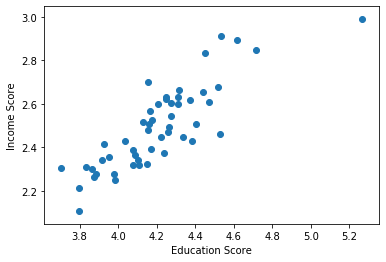

In [7]:
# Generate plot
plt.scatter(census_subset_df.groupby('STATE').mean().StateScore, irs_subset_df.groupby('STATE').mean().StateScore)

# Label the axes
plt.xlabel('Education Score')
plt.ylabel('Income Score')

# Display the plot
plt.show()

In [8]:
# Obtain Pearson Correlation Coefficient using numpy.corrcoef from entry [0,1] in the returned matrix. This 
# shows that there is a strong positive relationship between Education and Income.
np.corrcoef(census_subset_df.groupby('STATE').mean().StateScore, irs_subset_df.groupby('STATE').mean().StateScore)[0,1]

0.8451473713588781

In [9]:
# Obtain Covariance using numpy.cov from entry [0,1] in the returned matrix. This shows that Education 
# and Income vary together but not by much.
np.cov(census_subset_df.groupby('STATE').mean().StateScore, irs_subset_df.groupby('STATE').mean().StateScore)[0,1]

0.044349264307765396

# Step 6: Linear Regression
Perform a linear regression for both the 2011 and 2017 data. Then, perform pairs bootstrap estimates for the regression parameters. Report 95% confidence intervals on the slope and intercept of the regression line. (show how Education and Income change together over time)

In [15]:
# Define draw_bs_pairs_linreg function as explained in DataCamp online module (Statistical Thinking in Python - Part 2)
# to perform pairs bootstrap on a set of x,y data
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit( bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

In [16]:
# Compute the linear regressions
slope_2011, intercept_2011 = np.polyfit(edu_score_2011, income_score_2011, 1)
slope_2017, intercept_2017 = np.polyfit(edu_score_2017, income_score_2017, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_2011, bs_intercept_reps_2011 = draw_bs_pairs_linreg(edu_score_2011, income_score_2011, size=1000)
bs_slope_reps_2017, bs_intercept_reps_2017 = draw_bs_pairs_linreg(edu_score_2017, income_score_2017, size=1000)

# Compute confidence intervals of slopes
slope_conf_int_2011 = np.percentile(bs_slope_reps_2011,[2.5,97.5])
slope_conf_int_2017 = np.percentile(bs_slope_reps_2017,[2.5,97.5])
intercept_conf_int_2011 = np.percentile(bs_intercept_reps_2011,[2.5,97.5])
intercept_conf_int_2017 = np.percentile(bs_intercept_reps_2017,[2.5,97.5])

# Print the results
print('2011: slope =', slope_2011,'\n conf int =', slope_conf_int_2011)
print('2011: intercept =', intercept_2011,'\n conf int =', intercept_conf_int_2011)
print('2017: slope =', slope_2017,'\n conf int =', slope_conf_int_2017)
print('2017: intercept =', intercept_2017,'\n conf int =', intercept_conf_int_2017)

2011: slope = 0.5730035333136285 
 conf int = [0.56519918 0.57975577]
2011: intercept = 0.0202510167130084 
 conf int = [-0.00716226  0.05228661]
2017: slope = 0.6338488608392583 
 conf int = [0.62595627 0.64156267]
2017: intercept = -0.07934467649921674 
 conf int = [-0.11176053 -0.04728736]


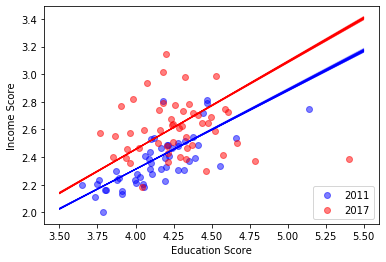

In [17]:
# Define variable for StateScore arrays for scatterplots (using ZipScores would result in "blobplot")
edu_state_score_2011 = census_subset_df[census_subset_df.YEAR == 2011].StateScore
edu_state_score_2017 = census_subset_df[census_subset_df.YEAR == 2017].StateScore

income_state_score_2011 = irs_subset_df[irs_subset_df.YEAR == 2011].StateScore
income_state_score_2017 = irs_subset_df[irs_subset_df.YEAR == 2017].StateScore


# Make scatter plot of 2011 data
_ = plt.scatter(edu_state_score_2011, income_state_score_2011, color='blue', alpha=0.5)

# Make scatter plot of 2017 data
_ = plt.scatter(edu_state_score_2017, income_state_score_2017, color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('Education Score')
_ = plt.ylabel('Income Score')
_ = plt.legend(('2011', '2017'), loc='lower right')

# Generate x-values for bootstrap lines: x
x = np.array([3.5, 5.5])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_2011[i*10]*x + bs_intercept_reps_2011[i*10],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2017[i*10]*x + bs_intercept_reps_2017[i*10],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

# Step 7: Calculate 95% bootstrap confidence interval 
Compare the mean ratio of Education Scores to Income Scores to show change in overall standard of living.

In [18]:
# Compute length-to-depth ratios
ratio_2011 = edu_score_2011/income_score_2011
ratio_2017 = edu_score_2017/income_score_2017

# Compute means
mean_ratio_2011 = np.mean(ratio_2011)
mean_ratio_2017 = np.mean(ratio_2017)

# Compute difference of means: ratio_mean_diff
ratio_mean_diff = mean_ratio_2017 - mean_ratio_2011

# Generate bootstrap replicates of the means
bs_replicates_2011 = draw_bs_reps(ratio_2011,np.mean,size=10000)
bs_replicates_2017 = draw_bs_reps(ratio_2017,np.mean,size=10000)

# Compute the 95% confidence intervals
conf_int_2011 = np.percentile(bs_replicates_2011,[2.5,97.5])
conf_int_2017 = np.percentile(bs_replicates_2017,[2.5,97.5])

# Print the results
print('2011: mean ratio =', mean_ratio_2011,
      '\n conf int =', conf_int_2011)
print('2017: mean ratio =', mean_ratio_2017,
      '\n conf int =', conf_int_2017)


2011: mean ratio = 1.7502179145812988 
 conf int = [1.74728143 1.7532865 ]
2017: mean ratio = 1.6439603567123413 
 conf int = [1.64124493 1.6467004 ]


# Step 8: Bootstrap hypothesis testing on ratios
Perform a bootstrap permutation test (like in Step 4) by shifting the two data sets so that they have the same mean. Then use bootstrap sampling to compute the difference of means.

In [19]:
# Compute mean of length-to-depth ratios: combined_ratio_mean
combined_ratio_mean = np.mean(np.concatenate((ratio_2011, ratio_2017)))

# Shift the samples
ratio_2011_shifted = ratio_2011 - np.mean(ratio_2011) + combined_ratio_mean
ratio_2017_shifted = ratio_2017 - np.mean(ratio_2017) + combined_ratio_mean

# Get bootstrap replicates of shifted data sets
bs_ratio_reps_2011 = draw_bs_reps(ratio_2011_shifted,np.mean,size=10000)
bs_ratio_reps_2017 = draw_bs_reps(ratio_2017_shifted,np.mean,size=10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_ratio_reps = bs_ratio_reps_2017 - bs_ratio_reps_2011

# Compute the p-value
p = np.sum(bs_diff_ratio_reps <= ratio_mean_diff) / len(bs_diff_ratio_reps)

# Print p-value
print('Ratio of Scores p =', p)

Ratio of Scores p = 0.0
